In [184]:
import numpy as np
from cvxopt import matrix, solvers

In [185]:
P = matrix([[1.0, 0.0], [0.0, 4.0]])
q = matrix([-8.0, -16.0])
G = matrix([[-1.0, 0.0, 1.0, -1.0], [0.0, -1.0, 1.0, 0.0]])
h = matrix([0.0, 0.0, 5.0, 3.0])

solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h)
print(sol['x'])


[ 2.40e+00]
[ 2.60e+00]



In [186]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform

    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.X = X
        self.y = y
        self.d = X.shape[1]
        self.weights_ = np.empty(self.d)
        self.bias_ = 0
        self.N = X.shape[0]

        P = np.block([[np.eye(self.d),     np.zeros((self.d, self.N+1))],
                      [np.zeros((self.N+1, self.d)), np.zeros((self.N+1, self.N+1))]
                    ])

        q = np.vstack((np.zeros(self.d+1)[:, None], self.C*np.ones(self.N)[:, None]))

        G = np.block([[-y[:, None] * X,         -y[:, None], -np.eye(self.N)],
                      [np.zeros((self.N, self.d+1)), -np.eye(self.N)]
                    ])

        h = np.vstack((-np.ones(self.N)[:, None], np.zeros(self.N)[:, None]))

        A = matrix(np.hstack((y, np.zeros((self.d+1))))[:, None].T)
        b = matrix(0.0)

        solvers.options['show_progress'] = False
        sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), A, b)
        self.weights_ = np.array(sol['x'])[:self.d]
        self.bias_ = np.array(sol['x'])[self.d][0]
        ksi = np.array(sol['x'])[self.d+1:]

        self.support_vectors = X[ksi.flatten() > 1e-3]
        self.support_labels = y[ksi.flatten() > 1e-3]


    def predict_proba(self, X):
        if X.ndim == 1:
          return (-self.weights_[0][0] * X + self.bias_) / self.weights_[1][0]
        return X @ self.weights_ + self.bias_

    def predict_proba_up(self, X):
        if X.ndim == 1:
          return (-self.weights_[0][0] * X + self.bias_ + 1) / self.weights_[1][0]
        return X @ self.weights_ + self.bias_  + 1

    def predict_proba_down(self, X):
        if X.ndim == 1:
          return (-self.weights_[0][0] * X + self.bias_ - 1) / self.weights_[1][0]
        return X @ self.weights_ + self.bias_ - 1

    def predict(self, X):
        return np.sign(self.predict_proba(X))

    def show(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='autumn', edgecolor='black')
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1],
                    c=self.support_labels, cmap='autumn', edgecolor='black',
                    marker='*')

        x_min, x_max = plt.xlim()
        xx = np.linspace(x_min, x_max, 100)

        y_min, y_max = plt.ylim()
        yy = np.linspace(y_min, y_max, 100)

        # zz = model.predict_proba(xx)
        # plt.plot(xx, zz)

        # zz_up = model.predict_proba_up(xx)
        # plt.plot(xx, zz_up)

        # zz_down = model.predict_proba_down(xx)
        # plt.plot(xx, zz_down)

        xx, yy = np.meshgrid(xx, yy)
        # Цветной фон, соответствующий значению решающего правила
        # plt.pcolormesh(xx, yy, model.predict(xx), cmap='autumn', zorder=0)
        zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        plt.contourf(xx, yy, zz, alpha=0.1, colors=['red', 'blue'])

        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        contour_levels = [-1, 0, 1]
        plt.contour(xx, yy, Z, levels=contour_levels, colors=['red', 'black', 'blue'],   # Разделяющая прямая и линии уровня
                  linestyles=['--', '-', '--'], linewidths=[1, 2, 1])

        plt.ylim(y_min, y_max)
        plt.title(f'C={C}, sv_num={len(self.support_vectors)}')
        plt.show()

# ГЕНЕРИРУЕМ ДАТАСЕТЫ

In [187]:
from sklearn.datasets import make_classification, make_moons, make_circles
import matplotlib.pyplot as plt

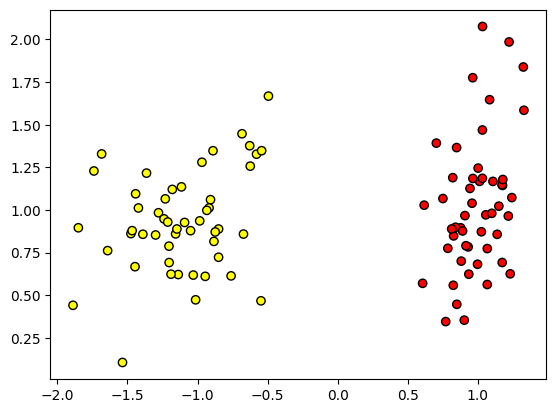

In [188]:
X1, y1 = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='autumn', edgecolor='black')
plt.show()

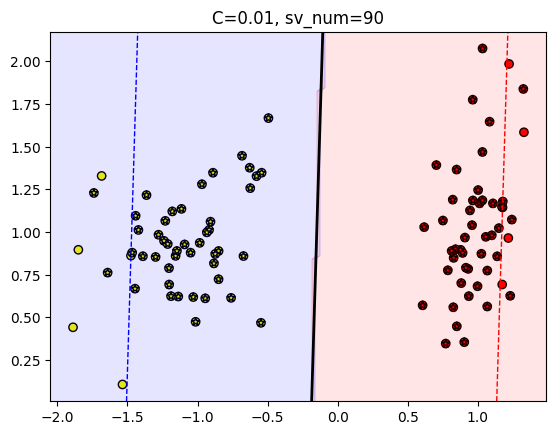

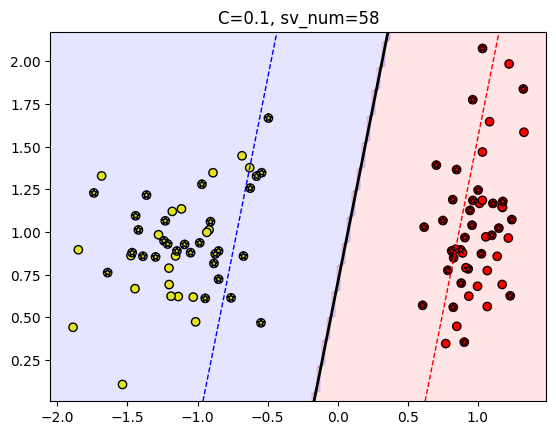

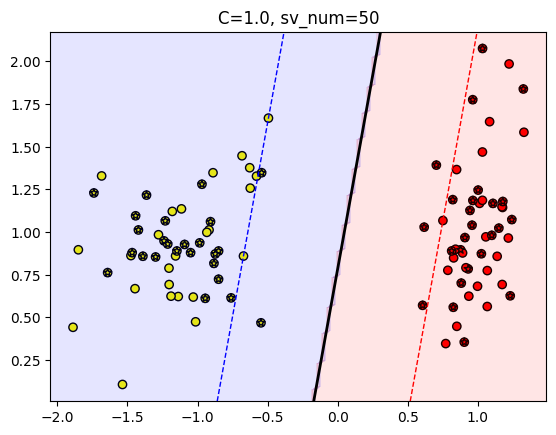

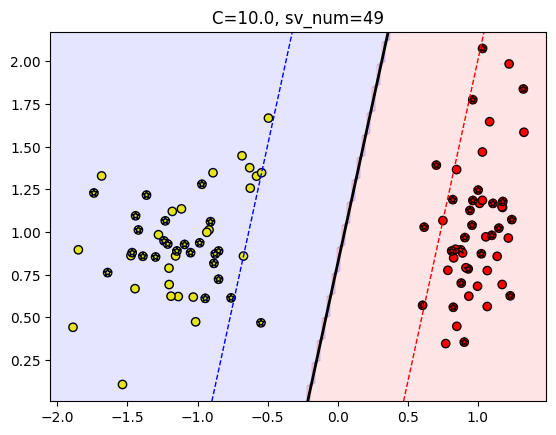

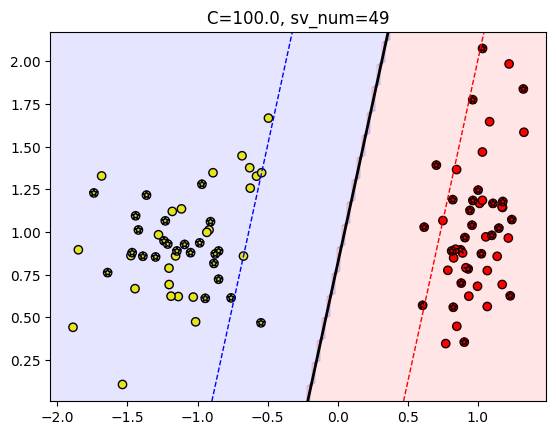

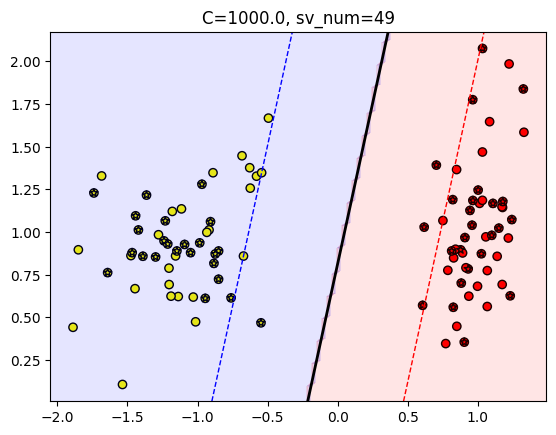

In [189]:
for C in np.logspace(-2, 3, 6):
  model = LinearSVM(C)
  model.fit(X1, y1 * 2 - 1)
  model.show()

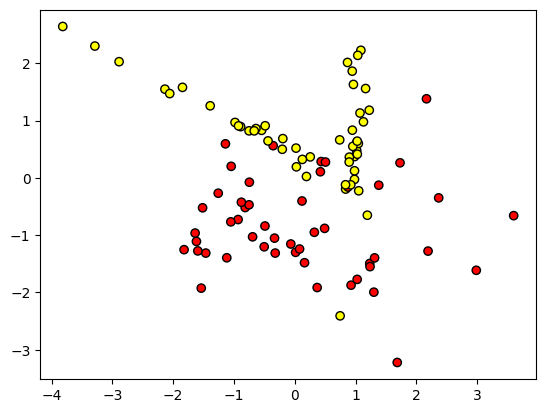

In [190]:
X2, y2 = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap='autumn', edgecolor='black')
plt.show()

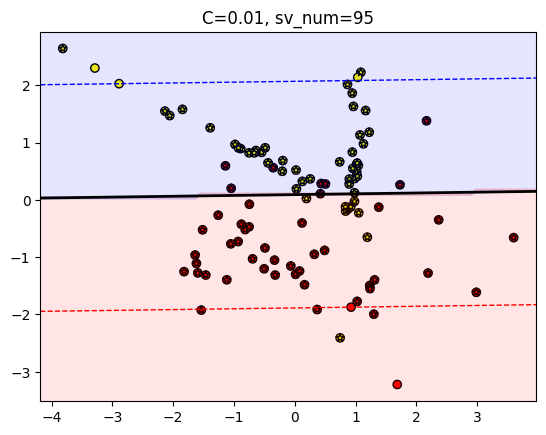

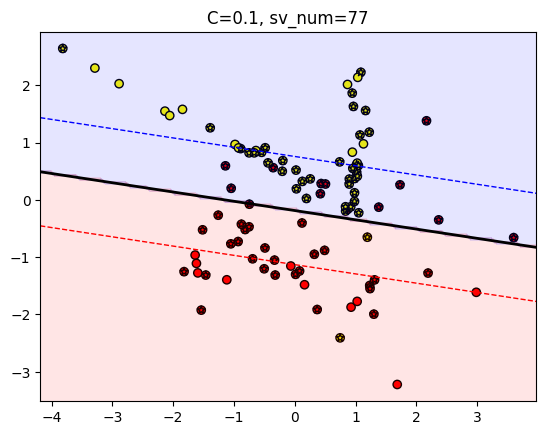

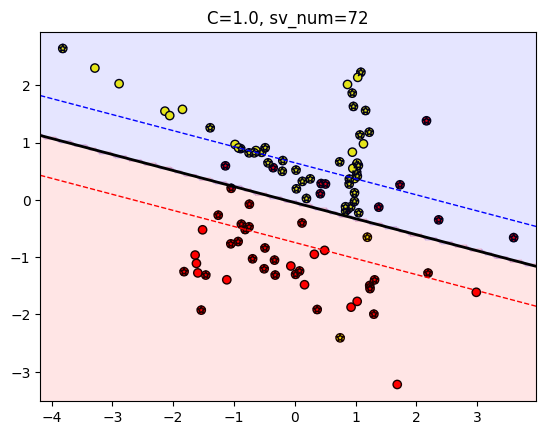

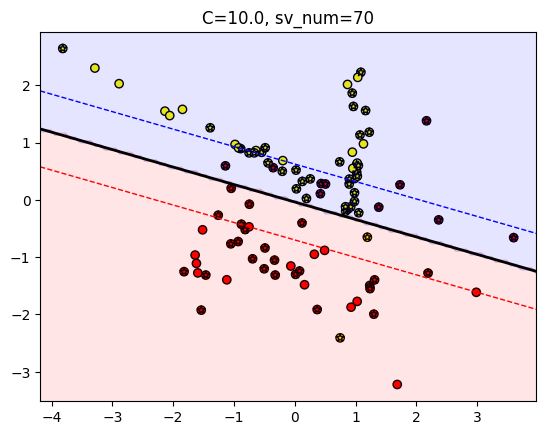

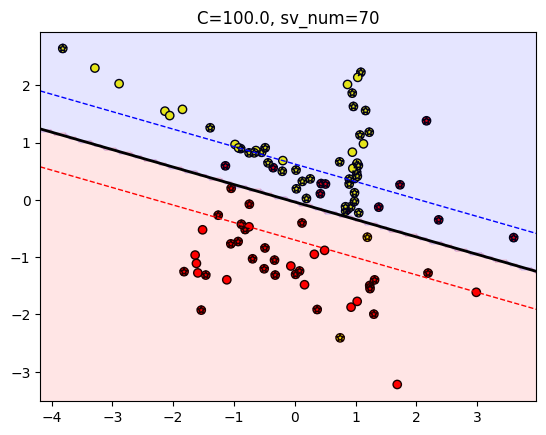

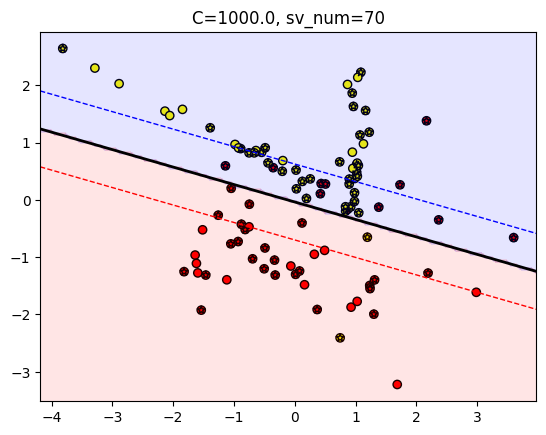

In [191]:
for C in np.logspace(-2, 3, 6):
  model = LinearSVM(C)
  model.fit(X2, y2 * 2 - 1)
  model.show()

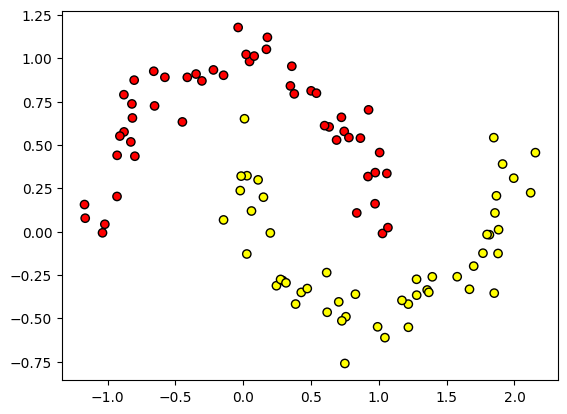

In [192]:
X3, y3 = make_moons(n_samples=100, random_state=1, noise=0.1)
plt.scatter(X3[:, 0], X3[:, 1], c=y3, cmap='autumn', edgecolor='black')
plt.show()

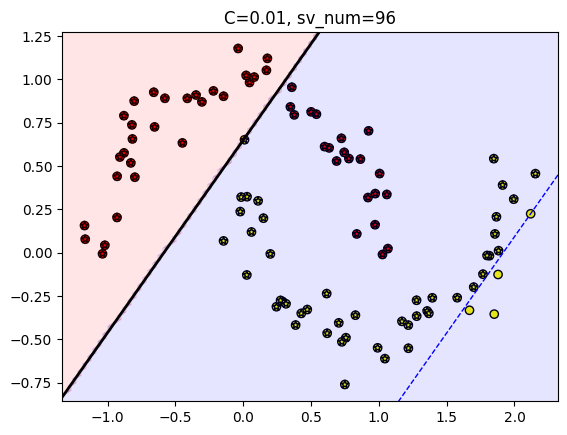

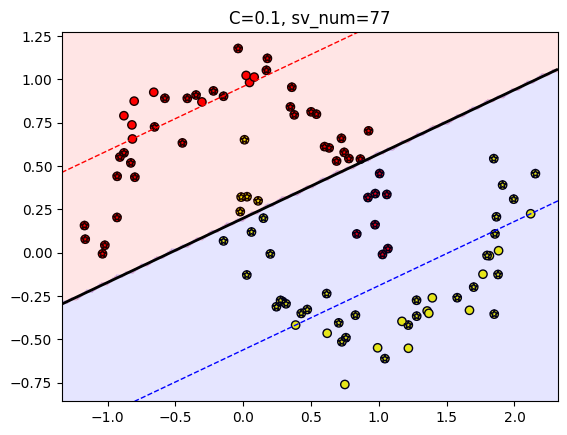

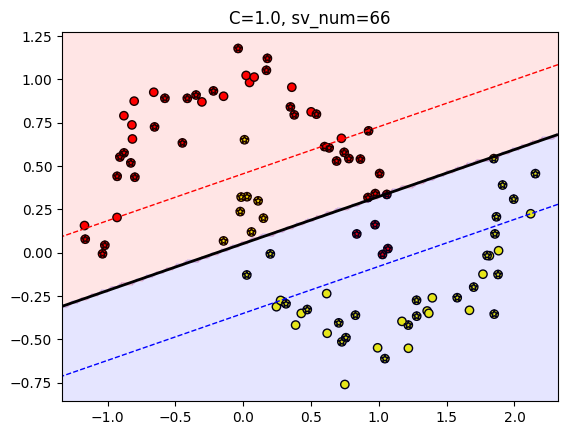

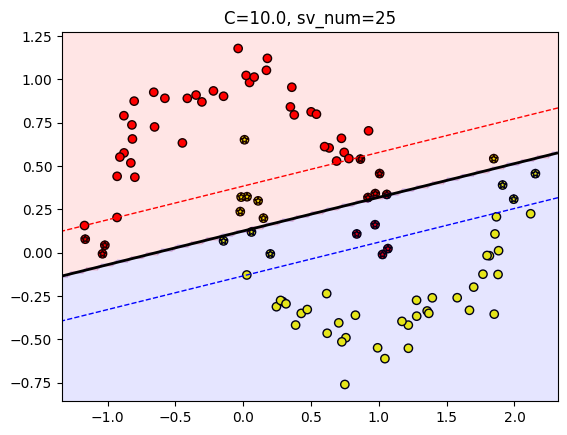

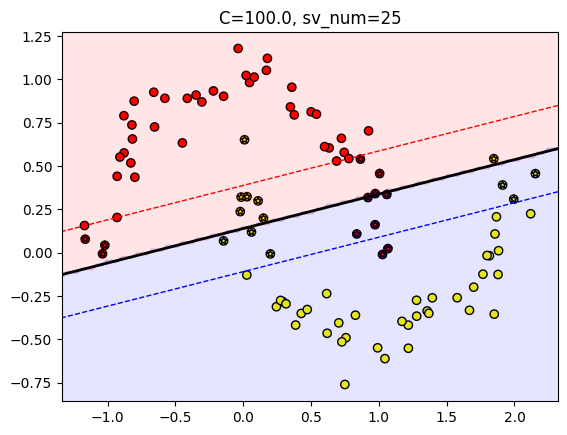

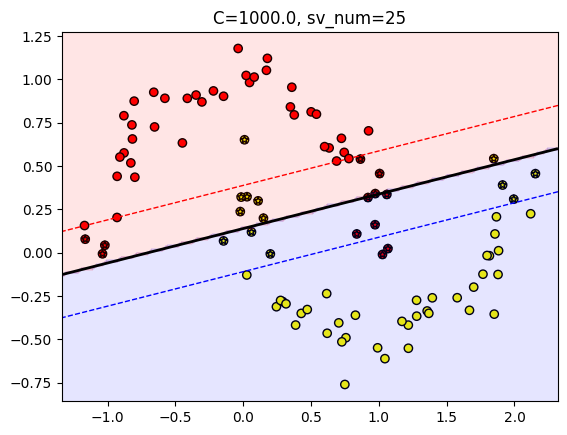

In [193]:
for C in np.logspace(-2, 3, 6):
  model = LinearSVM(C)
  model.fit(X3, y3 * 2 - 1)
  model.show()

In [194]:
class QuadraticSVM(LinearSVM):
    def __init__(self, C=1.0):
        super().__init__(C)

    def qua(self, X): # квадратичное преобразование
        return np.column_stack([
            X[:, 0], X[:, 1],
            X[:, 0]**2, X[:, 1]**2,
            X[:, 0] * X[:, 1]])

    def fit(self, X, y):
        X_quad = self.qua(X)
        super().fit(X_quad, y)

    def predict_proba(self, X):
        X_quad = self.qua(X)
        return super().predict_proba(X_quad)

    def predict_proba_up(self, X):
        X_quad = self.qua(X)
        return super().predict_proba_up(X_quad)

    def predict_proba_down(self, X):
        X_quad = self.qua(X)
        return super().predict_proba_down(X_quad)

    def predict(self, X):
        X_quad = self.qua(X)
        return super().predict(X_quad)

    def show(self):
        return super().show()

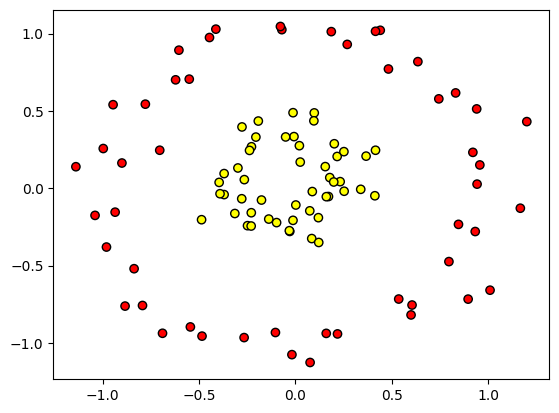

In [195]:
X4, y4 = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=3)
plt.scatter(X4[:, 0], X4[:, 1], c=y4, cmap='autumn', edgecolor='black')
plt.show()

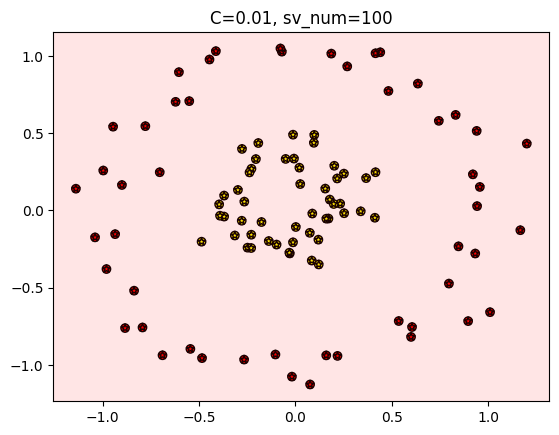

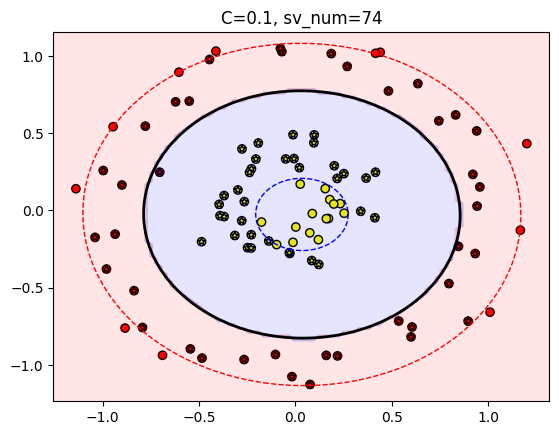

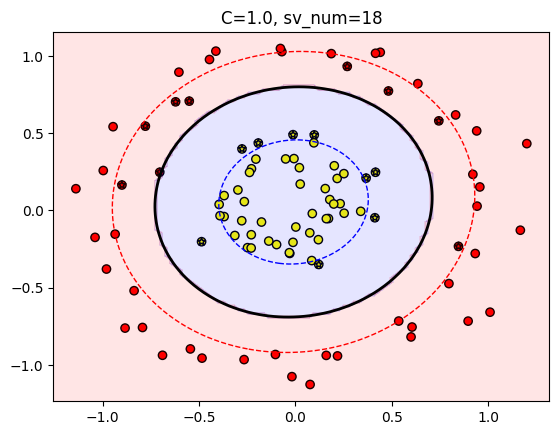

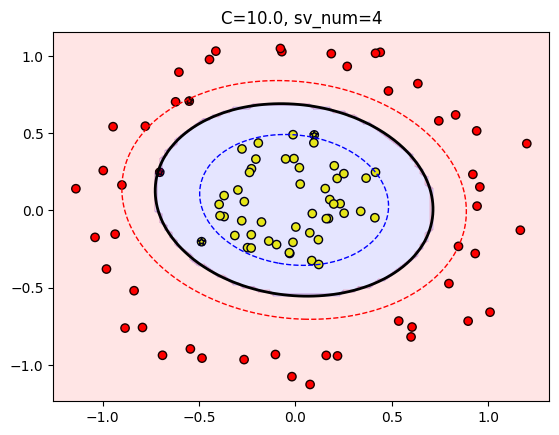

In [196]:
for C in np.logspace(-2, 1, 4):
  model = QuadraticSVM(C)
  model.fit(X4, y4 * 2 - 1)
  model.show()

In [205]:
class KernelSVM:
    def __init__(self, C=1.0, kernel='linear', degree=2, gamma=1.0):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.support_vectors = None
        self.support_labels = None
        self.es = None
        self.b = None
        self.X_train = None

    def _kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'poly':
            return (np.dot(x1, x2) + 1) ** self.degree
        elif self.kernel == 'rbf':
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)


    def _kernel_matrix(self, X1, X2):
        n1 = X1.shape[0]
        n2 = X2.shape[0]
        K = np.zeros((n1, n2))
        for i in range(n1):
            for j in range(n2):
                K[i, j] = self._kernel_function(X1[i], X2[j])
        return K

    def fit(self, X, y):
        self.X = X
        self.y = y
        n_samples, n_features = X.shape
        y = np.where(y == 0, -1, 1)

        self.X_train = X.copy()
        K = self._kernel_matrix(X, X)

        P = matrix(np.outer(y, y) * K.astype(np.double))
        q = matrix(-np.ones(n_samples).astype(np.double))

        G = matrix(np.vstack((
            -np.eye(n_samples),
            np.eye(n_samples))).astype(np.double))

        h = matrix(np.hstack((
            np.zeros(n_samples),
            np.ones(n_samples) * self.C)).astype(np.double))

        A = matrix(y.reshape(1, -1).astype(np.double))
        b = matrix(0.0)

        solution = solvers.qp(P, q, G, h, A, b)
        es = np.array(solution['x']).flatten()

        support_vector_ = es > 1e-5
        self.es = es[support_vector_]
        self.support_vectors = X[support_vector_]
        self.support_labels = y[support_vector_]

        self.b = 0
        for i in range(len(self.es)):
            if 1e-5 < self.es[i] < self.C - 1e-5:
                kernel_vals = self._kernel_matrix(self.support_vectors[i:i+1],
                                               self.support_vectors)
                self.b = self.support_labels[i] - np.sum(self.es * self.support_labels * kernel_vals.flatten())
                break


    def predict_proba(self, X):
        n_test = X.shape[0]
        n_support = len(self.support_vectors)

        K = np.zeros((n_test, n_support))
        for i in range(n_test):
            for j in range(n_support):
                K[i, j] = self._kernel_function(X[i], self.support_vectors[j])

        return np.dot(K, self.es * self.support_labels) + self.b

    def predict(self, X):
        return np.sign(self.predict_proba(X))

    def support_vectors_number(self):
        return len(self.support_vectors) if self.support_vectors is not None else 0

    def show(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='autumn', edgecolor='black')
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1],
                    c=self.support_labels, cmap='autumn', edgecolor='black',
                    marker='*')

        x_min, x_max = plt.xlim()
        xx = np.linspace(x_min, x_max, 100)

        y_min, y_max = plt.ylim()
        yy = np.linspace(y_min, y_max, 100)

        xx, yy = np.meshgrid(xx, yy)

        zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        plt.contourf(xx, yy, zz, alpha=0.1, colors=['red', 'blue'])

        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        contour_levels = [-1, 0, 1]
        plt.contour(xx, yy, Z, levels=contour_levels, colors=['red', 'black', 'blue'],   # Разделяющая прямая и линии уровня
                  linestyles=['--', '-', '--'], linewidths=[1, 2, 1])

        plt.ylim(y_min, y_max)
        plt.title(f'C={C}, sv_num={len(self.support_vectors)}')
        plt.show()


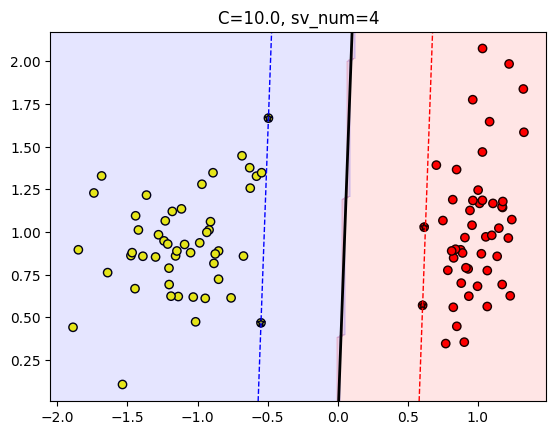

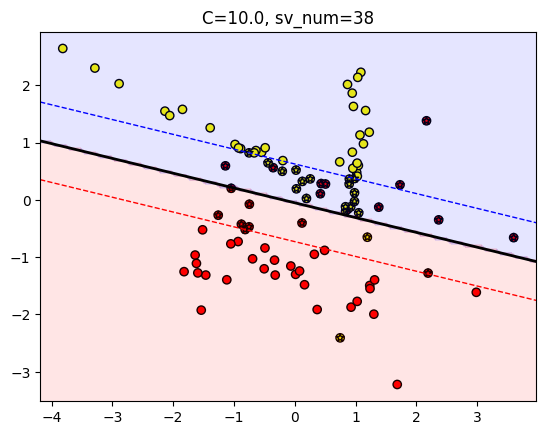

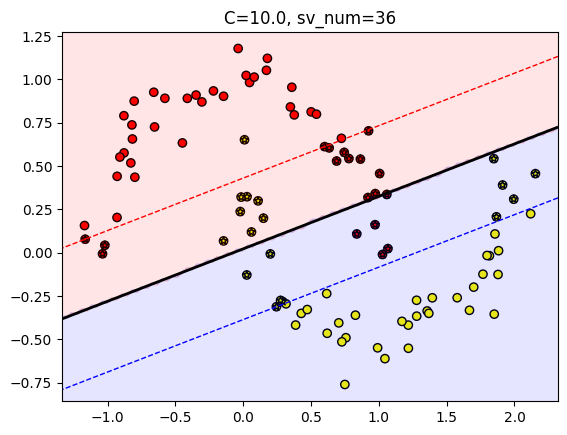

In [206]:
model = KernelSVM(C=1.0, kernel='linear')
model.fit(X1, y1)
model.show()

model = KernelSVM(C=1.0, kernel='linear')
model.fit(X2, y2)
model.show()

model = KernelSVM(C=1.0, kernel='linear')
model.fit(X3, y3)
model.show()

In [210]:
datasets = [
    (X1, y1, "Линейно разделимая"),
    (X2, y2, "Нелинейно разделимая"),
    (X3, y3, "Плохо разделимая")
]

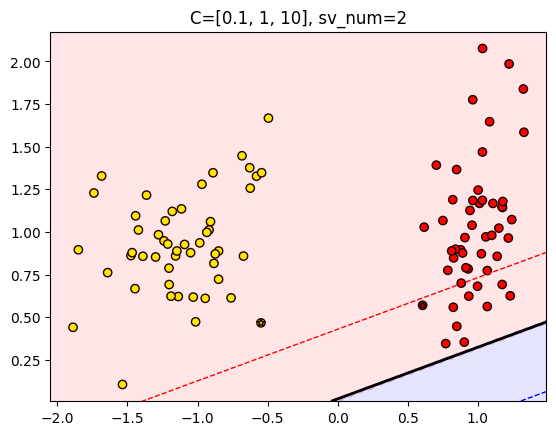

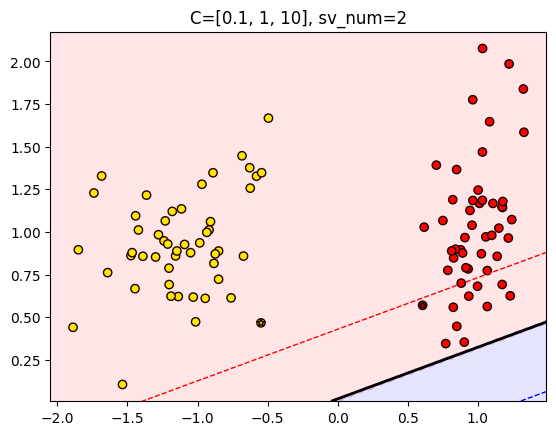

In [215]:
degrees = [2, 3]
for X, y, name in datasets[:1]:
    for j, degree in enumerate(degrees):
        svm = KernelSVM(C=1.0, kernel='poly', degree=degree)
        svm.fit(X, y)
        svm.show()

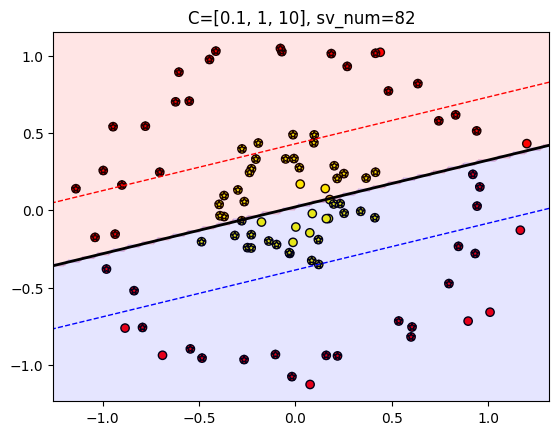

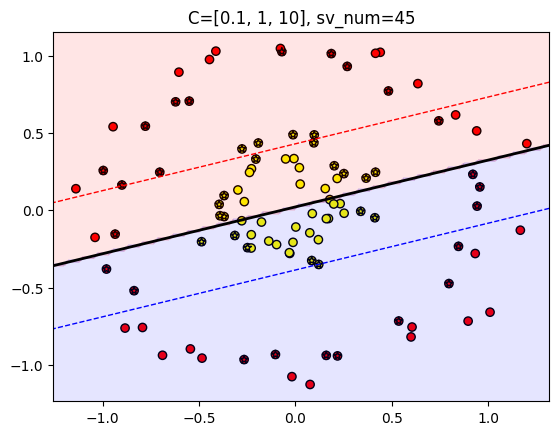

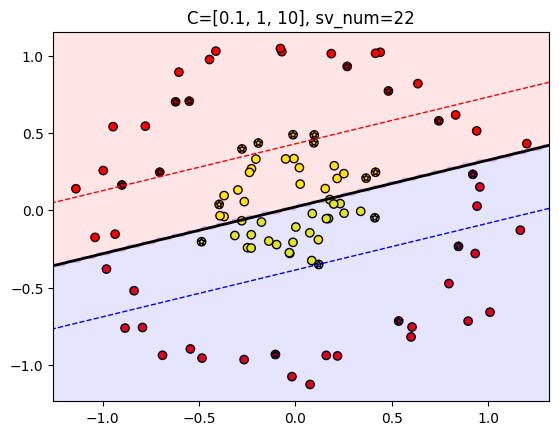

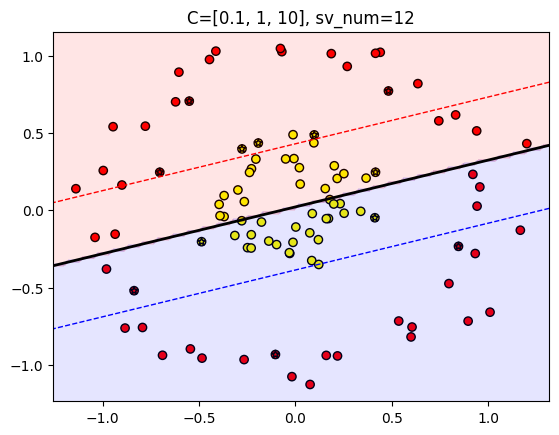

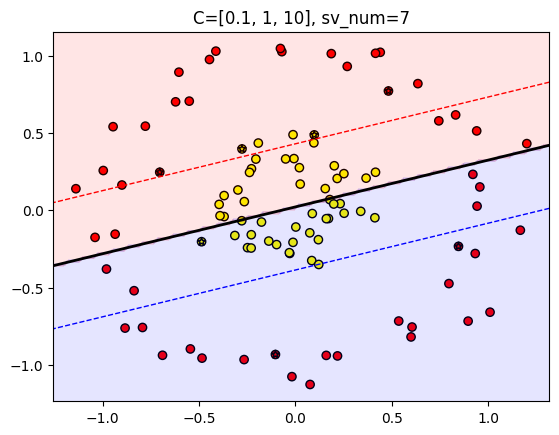

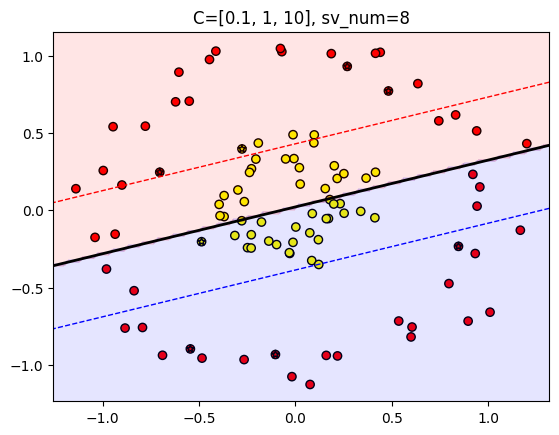

In [216]:
C = [0.1, 1, 10]
degrees = [2, 3]

X, y = X4, y4

for i, C_ in enumerate(C):
    for j, degree in enumerate(degrees):
        svm = KernelSVM(C=C_, kernel='poly', degree=degree)
        svm.fit(X, y)
        svm.show()

In [ ]:
class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform

    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.X = X
        self.y = y
        self.d = X.shape[1]
        self.weights_ = np.empty(self.d)
        self.bias_ = 0
        self.N = X.shape[0]

        P = np.block([[np.eye(self.d),     np.zeros((self.d, self.N+1))],
                      [np.zeros((self.N+1, self.d)), np.zeros((self.N+1, self.N+1))]
                    ])

        q = np.vstack((np.zeros(self.d+1)[:, None], self.C*np.ones(self.N)[:, None]))

        G = np.block([[-y[:, None] * X,         -y[:, None], -np.eye(self.N)],
                      [np.zeros((self.N, self.d+1)), -np.eye(self.N)]
                    ])

        h = np.vstack((-np.ones(self.N)[:, None], np.zeros(self.N)[:, None]))

        A = matrix(np.hstack((y, np.zeros((self.d+1))))[:, None].T)
        b = matrix(0.0)

        solvers.options['show_progress'] = False
        sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), A, b)
        self.weights_ = np.array(sol['x'])[:self.d]
        self.bias_ = np.array(sol['x'])[self.d][0]
        ksi = np.array(sol['x'])[self.d+1:]

        self.support_vectors = X[ksi.flatten() > 1e-3]
        self.support_labels = y[ksi.flatten() > 1e-3]


    def predict_proba(self, X):
        if X.ndim == 1:
          return (-self.weights_[0][0] * X + self.bias_) / self.weights_[1][0]
        return X @ self.weights_ + self.bias_

    def predict_proba_up(self, X):
        if X.ndim == 1:
          return (-self.weights_[0][0] * X + self.bias_ + 1) / self.weights_[1][0]
        return X @ self.weights_ + self.bias_  + 1

    def predict_proba_down(self, X):
        if X.ndim == 1:
          return (-self.weights_[0][0] * X + self.bias_ - 1) / self.weights_[1][0]
        return X @ self.weights_ + self.bias_ - 1

    def predict(self, X):
        return np.sign(self.predict_proba(X))

    def show(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='autumn', edgecolor='black')
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1],
                    c=self.support_labels, cmap='autumn', edgecolor='black',
                    marker='*')

        x_min, x_max = plt.xlim()
        xx = np.linspace(x_min, x_max, 100)

        y_min, y_max = plt.ylim()
        yy = np.linspace(y_min, y_max, 100)

        # zz = model.predict_proba(xx)
        # plt.plot(xx, zz)

        # zz_up = model.predict_proba_up(xx)
        # plt.plot(xx, zz_up)

        # zz_down = model.predict_proba_down(xx)
        # plt.plot(xx, zz_down)

        xx, yy = np.meshgrid(xx, yy)
        # Цветной фон, соответствующий значению решающего правила
        # plt.pcolormesh(xx, yy, model.predict(xx), cmap='autumn', zorder=0)
        zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        plt.contourf(xx, yy, zz, alpha=0.1, colors=['red', 'blue'])

        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        contour_levels = [-1, 0, 1]
        plt.contour(xx, yy, Z, levels=contour_levels, colors=['red', 'black', 'blue'],   # Разделяющая прямая и линии уровня
                  linestyles=['--', '-', '--'], linewidths=[1, 2, 1])

        plt.ylim(y_min, y_max)
        plt.title(f'C={C}, sv_num={len(self.support_vectors)}')
        plt.show()